<a href="https://colab.research.google.com/github/StanKozurno/rep_1/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research question

The research question of this study is:
What is the relation between alcohol consumption and alcohol related mortality?

# Motivation

Alcohol has historically been, and still is an important tool for socializing. And while for many it is pleasurable it is linked to many negative health effects, especially if consumed in excess. It is linked to many diseases, such as cancer and cirrhosis, road incidents and crime. The 2002 World Health Report ranks alcohol as the third highest death burden (9,2%) in established market economies, trailing only tobacco and blood pressure. In emerging societies, alcohol was the most important risk factor examined (Gmel, 2004). Globally alcohol consumption causes 2.8 million premature deaths per year. (Our world in data, 2022). 

However, given this information, one would expect that countries with the highest consumption of alcohol would be the ones with the highest rates of mortality, since alcohol is correlated so heavily with such a high death burden. On the first look it does not seem to be the case. The countries with high alcohol consumption are the ones with longest life expectancies (countries of the Global North) and countries with low alcohol consumptions tend to have lower levels of life expectancy. From the first look it also seems that alcohol consumption is correlated with income or GDP - rich countries seem to consume more alcohol than poor countries. In this project we want to dig deeper into this topic and find out if it really is the case.


# Method and data

The data consist of free different datasets - alcohol consumption per capita, alcohol related mortality per 100 000 habitants and GDP per capita. Data is on the country level for the years 1990 to 2018, depending on the dataset. The final dataset contains observation for years 2000, 2005, 2010, 2015 and 2018. It allows us to see the change in the observed factors over time. 

**Links to the datasets:**

Alcohol mortality https://vizhub.healthdata.org/gbd-results?params=gbd-api-2019-permalink/41bfbe98b4fc5597b3d925190c49d924

Alcohol consumption https://datacatalog.worldbank.org/search/dataset/0037712

GDP per capita https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators




First step of our analysis is data preparation. We transform the dataframes so they match one pattern and then we merge them into the single dataset. We define the functions that search the ISO code and continent for each country, using pycountry library. 

The next step is data visualization, where we included a few graphs to show a relations between alcohol consumption, alcohol related mortality and GDP per capita. Some of the graphs are interactive, to show what were the changes over time.

There are two columns with some missing observations - Alcohol consumption and GDP per capita. We will use  imputation techniques to generate the missing data - K Nearest Neighbour and  MICE from Fancyimpute package.

Imputation of K-nearest Neighbors Using all of the non-missing features, choose K nearest or similar data points, then take the average of the chosen data points to fill in the missing feature. In MICE method, multiple regressions are run on a random sample of the data. Then the average of those regression results is taken, and the missing feature value for the data point is imputed. We evaluate the imputation techniques and choose the best one to proceed with. We estimate and compare the linear models for datasets created by using each of the imputation technique. 

In the next step we run a linear regression using an ordinary least squared method. We will later compare it with the results obtained by the Bayesian regression.

# Main assumptions

In some cultures drinking alcohol is considered a sin and in some it is even prohibitted by the law, theoretically in those cultures there should be zero consumption of alcohol. We know however that that is not the case and we can see it in the data too. However, people from these cultures have an incentive to not report their true alcohol consumption and the true alcohol consumption remains unknown, and therefore we have to assume that the reported alcohol consumption is the true alcohol consumption for the purposes of this project

#Preview of the answer

Both OLS and Bayesian regressions gives similar estimates, which suggest a strong positive relationship between alcohol consumption and alcohol related mortality.  

# Conclusion and discussion

# Python code - data preparation

In [2]:
#installing the missing libraries - it takes a while, sorry about that
!pip install pycountry
!pip install pycountry_convert
!pip install altair_viewer
!pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=5955f632e8a69990fd97756314b59380ad513b2bff67ab7524b37f0e06ebc859
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 8.2 MB/s 
     |████████████████████████████████| 297 kB 53.3 MB/s 
     |████████████████████████████████| 297 kB 51.8 MB/s 
     |████████████████████████████████| 297 kB 60.2 MB/s 
     |████████████████████████████████| 296 kB 46.5 MB/s 
     |███████████████████████

In [3]:
#Libraries for data preparation and analysis
import numpy as np
import pandas as pd
import math
import missingno as msno
import statsmodels.api as sm

#Libraries used to search country ISO code and continent
import pycountry
import pycountry_convert as pc

# PyMC3 for Bayesian Inference
import pymc3 as pm

#libraries for data visualisation
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import altair_viewer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Data Science')

Mounted at /content/drive


In [5]:
#checking the working directory
!pwd

/content/drive/MyDrive/Data Science


In [6]:
#importing the datasets
risk=pd.read_csv('alcohol_risk.csv')
alcohol=pd.read_csv('alcohol_consumption.csv')
gdp=pd.read_csv('gdp-per-capita-worldbank.csv')
risk.head() 

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower
0,Deaths,Lao People's Democratic Republic,Male,All ages,All causes,Alcohol use,Rate,1990,73.696855,107.581026,46.478919
1,Deaths,Lao People's Democratic Republic,Female,All ages,All causes,Alcohol use,Rate,1990,16.514645,27.716536,8.093679
2,Deaths,Lao People's Democratic Republic,Both,All ages,All causes,Alcohol use,Rate,1990,44.583809,65.456324,27.665393
3,Deaths,Cambodia,Male,All ages,All causes,Alcohol use,Rate,1990,25.147936,40.086671,15.745914
4,Deaths,Cambodia,Female,All ages,All causes,Alcohol use,Rate,1990,6.703550,9.563247,4.545438


In [7]:
#defining a function analysing the dataset in terms of missing values and type of columns
def Analysis(data):
    print("Analysing")
    print(data.info())
    #calculating the share of missing values
    missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
    missing.columns=['Count', '%']
    missing = missing.sort_values(by='Count', ascending=False)
    print(missing)
    df=missing.iloc[0:5,0]

#analysing the first dataset
Analysis(alcohol)

Analysing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   800 non-null    object
 1   Country Code   798 non-null    object
 2   Series Name    798 non-null    object
 3   Series Code    798 non-null    object
 4   1997 [YR1997]  798 non-null    object
 5   1998 [YR1998]  798 non-null    object
 6   1999 [YR1999]  798 non-null    object
 7   2000 [YR2000]  798 non-null    object
 8   2001 [YR2001]  798 non-null    object
 9   2002 [YR2002]  798 non-null    object
 10  2003 [YR2003]  798 non-null    object
 11  2004 [YR2004]  798 non-null    object
 12  2005 [YR2005]  798 non-null    object
 13  2006 [YR2006]  798 non-null    object
 14  2007 [YR2007]  798 non-null    object
 15  2008 [YR2008]  798 non-null    object
 16  2009 [YR2009]  798 non-null    object
 17  2010 [YR2010]  798 non-null    object
 18  2011 [YR2011]  798 n

In [8]:
#converting NaN values to empty string
nan_value = float("NaN") 
alcohol.replace("", nan_value, inplace=True)
alcohol.replace("..", nan_value, inplace=True)
alcohol.dropna(subset = ["Country Code"], inplace=True)
alcohol.dropna(how='all', axis=1, inplace=True)
alcohol.tail()

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2005 [YR2005],2010 [YR2010],2015 [YR2015],2018 [YR2018]
793,Upper middle income,UMC,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,2.47289185170729,2.56488555274709,3.2264376937366,3.05922764679845,2.97565290858531
794,Upper middle income,UMC,"Total alcohol consumption per capita, male (li...",SH.ALC.PCAP.MA.LI,9.11499568520199,9.24095435101661,11.8686860962916,11.3133478387704,10.9681968239619
795,World,WLD,Total alcohol consumption per capita (liters o...,SH.ALC.PCAP.LI,5.48833592001259,5.42883274560048,6.28376529381833,6.29895560219615,6.18263453990771
796,World,WLD,"Total alcohol consumption per capita, female (...",SH.ALC.PCAP.FE.LI,2.41677855873695,2.40128503418862,2.69579450515509,2.66650870063011,2.6143378101529
797,World,WLD,"Total alcohol consumption per capita, male (li...",SH.ALC.PCAP.MA.LI,8.57460077546411,8.46375781956192,9.87635503128966,9.92837831418947,9.74729824850882


In [9]:
#renaming columns
alcohol.rename(columns={alcohol.columns[0]: "Country",alcohol.columns[2]: "Measure"}, inplace = True)
alcohol.rename(columns={alcohol.columns[1]: "ISO"}, inplace = True)


In [10]:
#dropping the column that we don't need
alcohol.drop(["Series Code"],axis=1,inplace=True)
alcohol.head()


,Country,ISO,Measure,2000 [YR2000],2005 [YR2005],2010 [YR2010],2015 [YR2015],2018 [YR2018]
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,NaN,NaN,0.21,0.21,0.21
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",NaN,NaN,0.054,0.054,0.055
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",NaN,NaN,0.36,0.35,0.36
3,Albania,ALB,Total alcohol consumption per capita (liters o...,6.57,7.65,7.69,6.74,7.17
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2.5,2.96,2.98,2.53,2.68


In [11]:
#melting years into a single column
alcohol = pd.melt(alcohol,id_vars=['Country','ISO','Measure'],
                        var_name='Year',
                        value_name='Rate')
alcohol.head()

,Country,ISO,Measure,Year,Rate
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,2000 [YR2000],NaN
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",2000 [YR2000],NaN
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",2000 [YR2000],NaN
3,Albania,ALB,Total alcohol consumption per capita (liters o...,2000 [YR2000],6.57
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2000 [YR2000],2.5


In [12]:
#renaming columns
alcohol.rename({'Measure':'Sex','Rate':'Alcohol consumption'},inplace=True,axis=1)

#there are redundant symbols in the column "Year", so we are keeping 4 left symbols in order to have only years 
alcohol["Year"] = alcohol["Year"].str[:4]

alcohol.head()

,Country,ISO,Sex,Year,Alcohol consumption
0,Afghanistan,AFG,Total alcohol consumption per capita (liters o...,2000,NaN
1,Afghanistan,AFG,"Total alcohol consumption per capita, female (...",2000,NaN
2,Afghanistan,AFG,"Total alcohol consumption per capita, male (li...",2000,NaN
3,Albania,ALB,Total alcohol consumption per capita (liters o...,2000,6.57
4,Albania,ALB,"Total alcohol consumption per capita, female (...",2000,2.5


In [13]:
#shortening names of the rows for "sex" column
alcohol['Sex'].replace({'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)':'Total',
                'Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)':'Female',
               'Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age)':'Male'},
               inplace=True)
#changing order of the columns
alcohol=alcohol[['Country','ISO','Year','Sex','Alcohol consumption']]
alcohol.head()

,Country,ISO,Year,Sex,Alcohol consumption
0,Afghanistan,AFG,2000,Total,NaN
1,Afghanistan,AFG,2000,Female,NaN
2,Afghanistan,AFG,2000,Male,NaN
3,Albania,ALB,2000,Total,6.57
4,Albania,ALB,2000,Female,2.5


In [14]:
#initial analysis of the first dataset
Analysis(risk)
risk.head()

Analysing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measure   18360 non-null  object 
 1   location  18360 non-null  object 
 2   sex       18360 non-null  object 
 3   age       18360 non-null  object 
 4   cause     18360 non-null  object 
 5   rei       18360 non-null  object 
 6   metric    18360 non-null  object 
 7   year      18360 non-null  int64  
 8   val       18360 non-null  float64
 9   upper     18360 non-null  float64
 10  lower     18360 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.5+ MB
None
          Count    %
measure       0  0.0
location      0  0.0
sex           0  0.0
age           0  0.0
cause         0  0.0
rei           0  0.0
metric        0  0.0
year          0  0.0
val           0  0.0
upper         0  0.0
lower         0  0.0


,measure,location,sex,age,cause,rei,metric,year,val,upper,lower
0,Deaths,Lao People's Democratic Republic,Male,All ages,All causes,Alcohol use,Rate,1990,73.696855,107.581026,46.478919
1,Deaths,Lao People's Democratic Republic,Female,All ages,All causes,Alcohol use,Rate,1990,16.514645,27.716536,8.093679
2,Deaths,Lao People's Democratic Republic,Both,All ages,All causes,Alcohol use,Rate,1990,44.583809,65.456324,27.665393
3,Deaths,Cambodia,Male,All ages,All causes,Alcohol use,Rate,1990,25.147936,40.086671,15.745914
4,Deaths,Cambodia,Female,All ages,All causes,Alcohol use,Rate,1990,6.703550,9.563247,4.545438


In [15]:
#droping the columns that we don't need
risk=risk.drop(columns=['age','upper','measure','rei','lower','cause','metric'])
risk.head()

,location,sex,year,val
0,Lao People's Democratic Republic,Male,1990,73.696855
1,Lao People's Democratic Republic,Female,1990,16.514645
2,Lao People's Democratic Republic,Both,1990,44.583809
3,Cambodia,Male,1990,25.147936
4,Cambodia,Female,1990,6.703550


In [16]:
#defining a function that will search for a country ISO code based on its name, using pycountry database
def country_code (country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except:
        return ("not founded")
  
#applying the function to add a new column with ISO codes to the dataset
risk['ISO'] = risk.apply(lambda row: country_code(row.location) , axis = 1)

In [17]:
#renaming the columns to match the names in the main dataset
risk.rename({'location':'Country', 'year':'Year','val':'Alcohol disorders','sex':'Sex'},inplace=True,axis=1)
#changing the columns order
risk=risk[['Country','ISO','Year','Alcohol disorders','Sex']]
#changing the values of the "Sex" column
risk['Sex'].replace({'Both':'Total'}, inplace=True)
risk.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Country,ISO,Year,Alcohol disorders,Sex
0,Lao People's Democratic Republic,LAO,1990,73.696855,Male
1,Lao People's Democratic Republic,LAO,1990,16.514645,Female
2,Lao People's Democratic Republic,LAO,1990,44.583809,Total
3,Cambodia,KHM,1990,25.147936,Male
4,Cambodia,KHM,1990,6.703550,Female


In [18]:
#checking properties of the datasets
risk.info()
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            18360 non-null  object 
 1   ISO                18360 non-null  object 
 2   Year               18360 non-null  int64  
 3   Alcohol disorders  18360 non-null  float64
 4   Sex                18360 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 717.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3990 entries, 0 to 3989
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Country              3990 non-null   object
 1   ISO                  3990 non-null   object
 2   Year                 3990 non-null   object
 3   Sex                  3990 non-null   object
 4   Alcohol consumption  3492 non-null   object
dtypes: object(5)
memory usage: 156.0+ KB


In [19]:
#changing the type of columns to numeric
alcohol["Year"] = pd.to_numeric(alcohol["Year"])
alcohol["Alcohol consumption"] = pd.to_numeric(alcohol["Alcohol consumption"])


In [20]:
#merging the alcohol and risk datasets
alcohol=alcohol.merge(risk,how='inner',on=['Country','ISO','Year','Sex'])
alcohol.head(300)

,Country,ISO,Year,Sex,Alcohol consumption,Alcohol disorders
0,Afghanistan,AFG,2000,Total,NaN,2.195427
1,Afghanistan,AFG,2000,Female,NaN,1.857283
2,Afghanistan,AFG,2000,Male,NaN,2.525603
3,Albania,ALB,2000,Total,6.570,16.023987
4,Albania,ALB,2000,Female,2.500,4.338308
...,...,...,...,...,...,...
295,Marshall Islands,MHL,2000,Female,NaN,1.402308
296,Marshall Islands,MHL,2000,Male,NaN,28.740948
297,Mauritania,MRT,2000,Total,0.200,5.420559
298,Mauritania,MRT,2000,Female,0.053,3.160113


In [21]:
#renaming the columns so they match the first dataset
gdp.rename({'Entity':'Country','GDP per capita, PPP (constant 2017 international $)':'GDP per capita','Code':'ISO'},inplace=True,axis=1)
gdp.head()

,Country,ISO,Year,GDP per capita
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117


In [22]:
#
Analysis(gdp)

Analysing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         7109 non-null   object 
 1   ISO             5729 non-null   object 
 2   Year            7109 non-null   int64  
 3   GDP per capita  7109 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 222.3+ KB
None
                Count          %
ISO              1380  19.412013
Country             0   0.000000
Year                0   0.000000
GDP per capita      0   0.000000


In [23]:
#merging the datasets
alcohol=alcohol.merge(gdp,how='left',left_on=['Country','ISO','Year'], 
                      right_on=['Country','ISO','Year'])
alcohol.tail(300)

,Country,ISO,Year,Sex,Alcohol consumption,Alcohol disorders,GDP per capita
2310,Iraq,IRQ,2018,Total,0.39,1.912586,10346.212958
2311,Iraq,IRQ,2018,Female,0.11,0.200741,10346.212958
2312,Iraq,IRQ,2018,Male,0.67,3.542651,10346.212958
2313,Ireland,IRL,2018,Total,12.88,30.650402,84303.340892
2314,Ireland,IRL,2018,Female,6.38,17.248742,84303.340892
...,...,...,...,...,...,...,...
2605,Zambia,ZMB,2018,Female,2.62,14.014648,3521.542063
2606,Zambia,ZMB,2018,Male,10.62,62.351931,3521.542063
2607,Zimbabwe,ZWE,2018,Total,4.67,34.143938,3341.665418
2608,Zimbabwe,ZWE,2018,Female,1.63,6.197438,3341.665418


In [24]:
#function that will search for a correct continent using country name and code
def country_to_continent(Country):
    try:
      country_alpha2 = pc.country_name_to_country_alpha2(Country)
      country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
      country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
      return country_continent_name
    except:
      return (np.nan)

#applying the function to add a new column with continents to the dataset
alcohol['Continent'] = alcohol.apply(lambda row: country_to_continent(row.Country) , axis = 1)

#changing order of the columns
alcohol=alcohol[['Country','ISO','Continent','Year','Sex','Alcohol disorders','Alcohol consumption','GDP per capita']]

In [25]:
print(alcohol[alcohol['Continent']=='Europe'])

             Country  ISO Continent  Year     Sex  Alcohol disorders  \
3            Albania  ALB    Europe  2000   Total          16.023987   
4            Albania  ALB    Europe  2000  Female           4.338308   
5            Albania  ALB    Europe  2000    Male          27.721352   
12           Andorra  AND    Europe  2000   Total          46.079610   
13           Andorra  AND    Europe  2000  Female          19.549261   
...              ...  ...       ...   ...     ...                ...   
2587         Ukraine  UKR    Europe  2018  Female          25.892492   
2588         Ukraine  UKR    Europe  2018    Male         190.892966   
2592  United Kingdom  GBR    Europe  2018   Total          37.323664   
2593  United Kingdom  GBR    Europe  2018  Female          18.741195   
2594  United Kingdom  GBR    Europe  2018    Male          56.321671   

      Alcohol consumption  GDP per capita  
3                    6.57     5893.136233  
4                    2.50     5893.136233  
5  

# Data visualisation

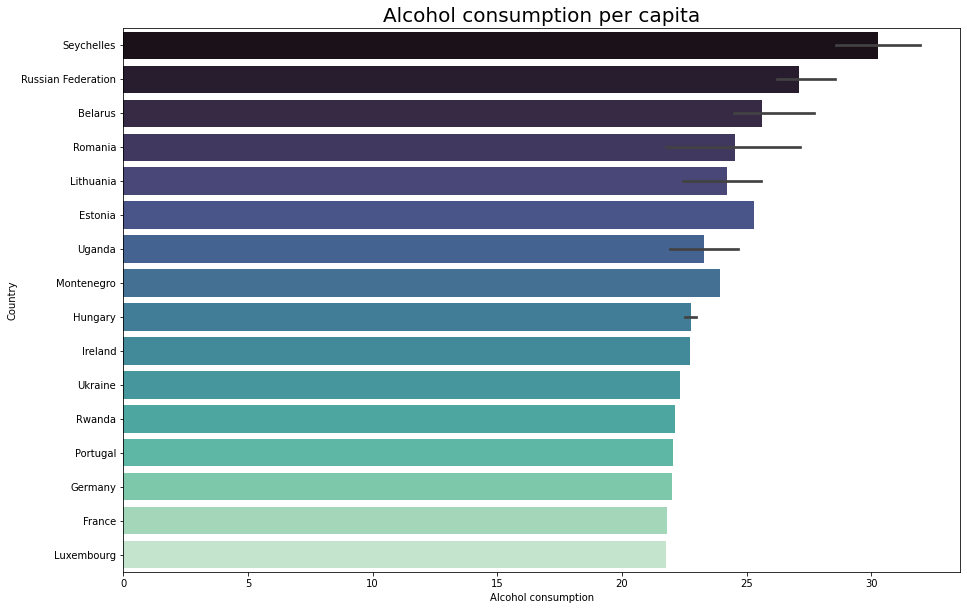

In [26]:
#plotting the 30 largest countries in terms of alcohol consumption
plt.figure(figsize = (15,10))
sns.barplot(x ='Alcohol consumption',y= 'Country',
            #choosing the 30 largest countries in terms of alcohol consumption
            data = alcohol.nlargest(30,'Alcohol consumption',keep='first'),palette='mako')
plt.title('Alcohol consumption per capita', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


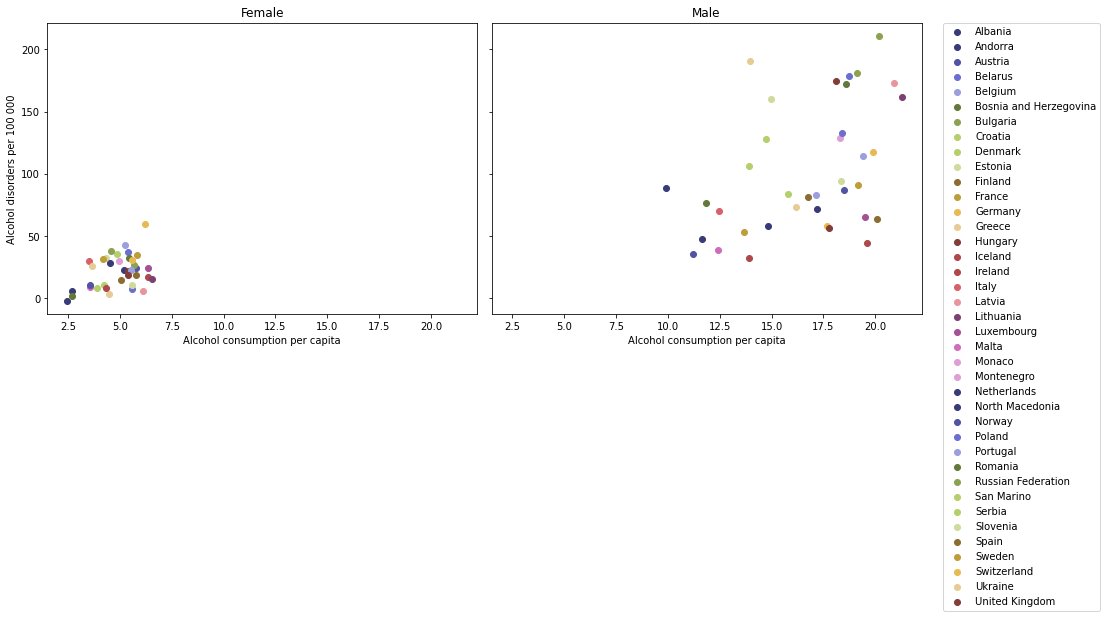

In [27]:
# Visualizing relation between alcohol consumption and mortality for Europe

plt.style.use('seaborn-dark-palette')
NUM_COLORS = 24

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

#selecting data for Europe in 2018

alcohol_europe = alcohol[alcohol['Continent']=='Europe']
alcohol_europe = alcohol_europe[alcohol_europe['Year']==2018]
#defining the subplots
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,figsize=(13,5))

#loop filtering the observations for each country
for Country in alcohol_europe.Country.unique():
    mask = (alcohol_europe.Country == Country)
    #adding observations on a scatterplot for each gender
    ax1.scatter(alcohol_europe[mask&(alcohol_europe.Sex=='Female')]['Alcohol consumption'], alcohol_europe[mask&(alcohol.Sex=='Female')]['Alcohol disorders'], label = Country)
    ax2.scatter(alcohol_europe[mask&(alcohol_europe.Sex=='Male')]['Alcohol consumption'], alcohol_europe[mask&(alcohol.Sex=='Male')]['Alcohol disorders'], label = Country)

#setting labels
ax1.set_xlabel('Alcohol consumption per capita')
ax2.set_xlabel('Alcohol consumption per capita')
ax1.set_ylabel('Alcohol disorders per 100 000')
ax1.set_title('Female')
ax2.set_title('Male')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


On the plot above we can see that the average alcohol consumption in European countries is significantly larger for men.

In [28]:
#interactive map visualising the alcohol consumption worldwide with animation, showing the change over time
fig = px.choropleth(alcohol, locations="ISO",
                    color="Alcohol consumption", # this is a visualised variable
                    hover_name="Country", # column to add to hover information
                    animation_frame="Year", animation_group="Country", # shows development over time using animation
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [29]:
#interactive map visualising the alcohol related mortality by country, showing the change over time

fig = px.choropleth(alcohol, locations="ISO", #ISO is used to recognize a country
                    color="Alcohol disorders", # this is a visualised column
                    hover_name="Country", # column to add to hover information
                    animation_frame="Year", animation_group="Country", #shows development over time using animation
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [30]:
alcohol_graph=alcohol[alcohol['Sex']=='Total']
alcohol_graph=alcohol.dropna()
alcohol_graph.head()

,Country,ISO,Continent,Year,Sex,Alcohol disorders,Alcohol consumption,GDP per capita
3,Albania,ALB,Europe,2000,Total,16.023987,6.57,5893.136233
4,Albania,ALB,Europe,2000,Female,4.338308,2.50,5893.136233
5,Albania,ALB,Europe,2000,Male,27.721352,10.60,5893.136233
6,Algeria,DZA,Africa,2000,Total,2.012620,0.58,8710.455149
7,Algeria,DZA,Africa,2000,Female,0.425509,0.16,8710.455149


In [31]:
#Interactive scatterplot showing a relation between alcohol consumption and alcohol related mortality by country,
#GDP per capita determines the size of the bubble. It also visualizes change over time using animation.

fig = px.scatter(alcohol_graph, x="Alcohol consumption", y="Alcohol disorders", 
	         size="GDP per capita", color="Continent", #size of the bubbles is determined by GDP per capita
                 hover_name="Country", log_x=True, size_max=60, #using logarithm of alcohol consumption
                 animation_frame="Year", animation_group="Country") #animation settings

fig.show()





# Dealing with missing data

In [32]:
#checking the share of missing data using the function defined earlier
Analysis(alcohol)

Analysing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2610 entries, 0 to 2609
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              2610 non-null   object 
 1   ISO                  2610 non-null   object 
 2   Continent            2595 non-null   object 
 3   Year                 2610 non-null   int64  
 4   Sex                  2610 non-null   object 
 5   Alcohol disorders    2610 non-null   float64
 6   Alcohol consumption  2412 non-null   float64
 7   GDP per capita       2373 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 248.1+ KB
None
                     Count         %
GDP per capita         237  9.080460
Alcohol consumption    198  7.586207
Continent               15  0.574713
Country                  0  0.000000
ISO                      0  0.000000
Year                     0  0.000000
Sex                      0  0.000000
Alcohol disorders  

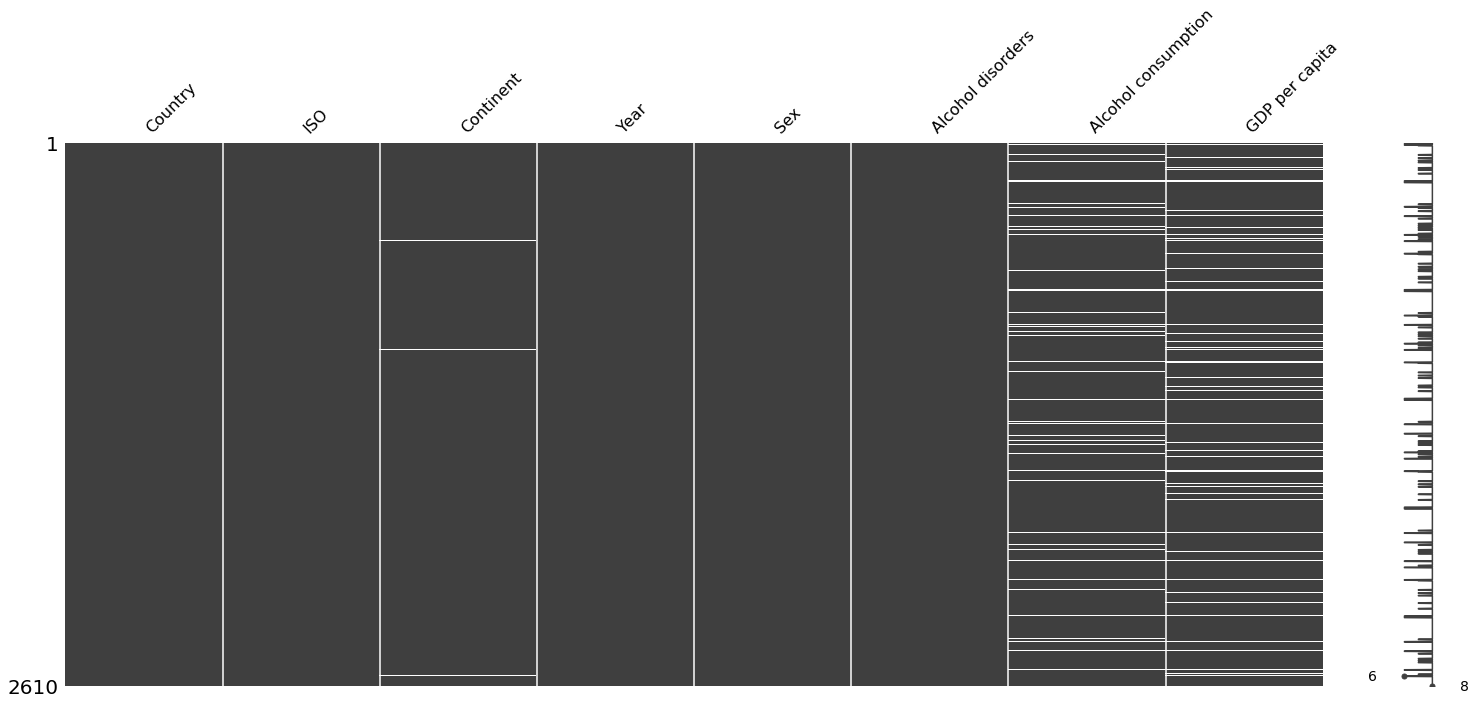

In [33]:
#summary of missingness using the missingno library - white lines represent missing observations
msno.matrix(alcohol)
#msno.heatmap(alcohol)

There are two columns with the largest amounts of missing observations - Alcohol consumption and GDP per capita. We will use  imputation techniques to generate the missing data - K Nearest Neighbour and  MICE from Fancyimpute package.

Imputation of K-nearest Neighbors Using all of the non-missing features, choose K nearest or similar data points, then take the average of the chosen data points to fill in the missing feature.

In MICE method, multiple regressions are run on a random sample of the data. Then the average of those regression results is taken, and the missing feature value for the data point is imputed.

Finally, we will evaluate the imputation techniques and choose the best one to proceed with. We will estimate and compare the linear models estimated for datasets created by using each of the imputation technique. 


In [34]:
# K-Nearest Neighbour imputation
from fancyimpute import KNN
from sklearn.preprocessing import MinMaxScaler
# Initializing imputer and scaler
knn_imputer = KNN()
scaler = MinMaxScaler()

# Selecting columns with the numerical variables
alcohol_knn = alcohol.iloc[:,-3:]
# Normalization of data using MinMaxScaler, which rescales variables into the range [0,1]
alcohol_knn = pd.DataFrame(scaler.fit_transform(alcohol_knn), columns = alcohol_knn.columns)

# Imputing the missing observations
alcohol_knn.iloc[:,:] = knn_imputer.fit_transform(alcohol_knn)
alcohol_knn.head()

Imputing row 1/2610 with 2 missing, elapsed time: 1.712
Imputing row 101/2610 with 0 missing, elapsed time: 1.715
Imputing row 201/2610 with 0 missing, elapsed time: 1.717
Imputing row 301/2610 with 0 missing, elapsed time: 1.719
Imputing row 401/2610 with 0 missing, elapsed time: 1.722
Imputing row 501/2610 with 0 missing, elapsed time: 1.724
Imputing row 601/2610 with 0 missing, elapsed time: 1.726
Imputing row 701/2610 with 0 missing, elapsed time: 1.728
Imputing row 801/2610 with 0 missing, elapsed time: 1.730
Imputing row 901/2610 with 0 missing, elapsed time: 1.732
Imputing row 1001/2610 with 0 missing, elapsed time: 1.735
Imputing row 1101/2610 with 0 missing, elapsed time: 1.738
Imputing row 1201/2610 with 0 missing, elapsed time: 1.741
Imputing row 1301/2610 with 0 missing, elapsed time: 1.744
Imputing row 1401/2610 with 0 missing, elapsed time: 1.746
Imputing row 1501/2610 with 0 missing, elapsed time: 1.749
Imputing row 1601/2610 with 0 missing, elapsed time: 1.752
Imputing 

,Alcohol disorders,Alcohol consumption,GDP per capita
0,0.014826,0.007384,0.163165
1,0.013884,0.033292,0.288106
2,0.015746,0.020238,0.056212
3,0.053344,0.205569,0.046587
4,0.020795,0.078223,0.046587


In [35]:
# MICE imputation
from fancyimpute import IterativeImputer
# Initializing the imputer
MICE_imputer = IterativeImputer()

alcohol_mice = alcohol.iloc[:,-3:]
# Normalization of data using MinMaxScaler, which rescales variables into the range [0,1]
alcohol_mice = pd.DataFrame(scaler.fit_transform(alcohol_mice), columns = alcohol_mice.columns)

# Imputing the missing observations
alcohol_mice.iloc[:, :] = MICE_imputer.fit_transform(alcohol_mice)
alcohol_mice.head()

,Alcohol disorders,Alcohol consumption,GDP per capita
0,0.014826,0.069984,0.150330
1,0.013884,0.068713,0.150219
2,0.015746,0.071226,0.150439
3,0.053344,0.205569,0.046587
4,0.020795,0.078223,0.046587


In [36]:
# Creating a baseline dataset with complete observations  
alcohol_lm = alcohol.iloc[:,-3:]
alcohol_lm = alcohol_lm.dropna(how='any')
alcohol_lm = pd.DataFrame(scaler.fit_transform(alcohol_lm), columns = alcohol_lm.columns)

# Estimating a linear model with a baseline data
X1 = sm.add_constant(alcohol_lm[['Alcohol consumption','GDP per capita']])
y1 = alcohol_lm['Alcohol disorders']
lm = sm.OLS(y1, X1).fit()

# Print summary of lm
print('\nSummary: ', lm.summary())

# Print R squared score of lm
print('\nAdjusted R-squared score: ', lm.rsquared_adj)

# Print the params of lm
print('\nCoefficcients:\n', lm.params)


Summary:                              OLS Regression Results                            
Dep. Variable:      Alcohol disorders   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     2461.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:49:51   Log-Likelihood:                 2348.1
No. Observations:                2268   AIC:                            -4690.
Df Residuals:                    2265   BIC:                            -4673.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [37]:
# Estimating linear regression for the KNN method
X2 = sm.add_constant(alcohol_knn[['Alcohol consumption','GDP per capita']])
y2 = alcohol_knn['Alcohol disorders']
lm_KNN = sm.OLS(y2, X2).fit()
print('\nSummary: ', lm_KNN.summary())
print('\nAdjusted R-squared score: ', lm_KNN.rsquared_adj)
print('\nCoefficcients:\n', lm_KNN.params)


Summary:                              OLS Regression Results                            
Dep. Variable:      Alcohol disorders   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2923.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:49:51   Log-Likelihood:                 3762.4
No. Observations:                2610   AIC:                            -7519.
Df Residuals:                    2607   BIC:                            -7501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [38]:
# Estimating linear regression for the MICE method
X3 = sm.add_constant(alcohol_mice[['Alcohol consumption','GDP per capita']])
y3= alcohol_mice['Alcohol disorders']
lm_MICE = sm.OLS(y3, X3).fit()
print('\nAdjusted R-squared score: ', lm_MICE.rsquared_adj)
print('\nCoefficcients:\n', lm_MICE.params)


Adjusted R-squared score:  0.7007396886520973

Coefficcients:
 const                  0.020876
Alcohol consumption    0.528663
GDP per capita        -0.111056
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [39]:
# Store the Adj. R-squared scores of the linear models
r_squared = pd.DataFrame({'Complete Case': lm.rsquared_adj, 
                          'KNN Imputation': lm_KNN.rsquared_adj, 
                          'MICE Imputation': lm_MICE.rsquared_adj}, 
                         index=['Adj. R-squared'])

print(r_squared)

                Complete Case  KNN Imputation  MICE Imputation
Adj. R-squared       0.684606        0.691343          0.70074


Text(0.5, 0, 'Alcohol consumption')

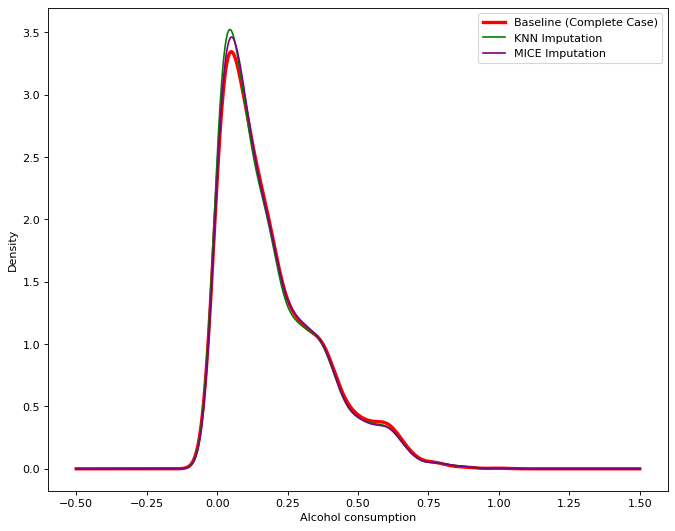

In [40]:
from matplotlib.pyplot import figure
# Setting size of the plot
figure(figsize=(10, 8), dpi=80)

# Adding density plots for different imputation to the plot for alcohol consumption
alcohol_lm['Alcohol consumption'].plot(kind='kde', c='red', linewidth=3)
alcohol_knn['Alcohol consumption'].plot(kind='kde', c='green')
alcohol_mice['Alcohol consumption'].plot(kind='kde',c='purple')
# Adding labels
labels = ['Baseline (Complete Case)', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)
plt.xlabel('Alcohol consumption')


Text(0.5, 0, 'GDP per capita')

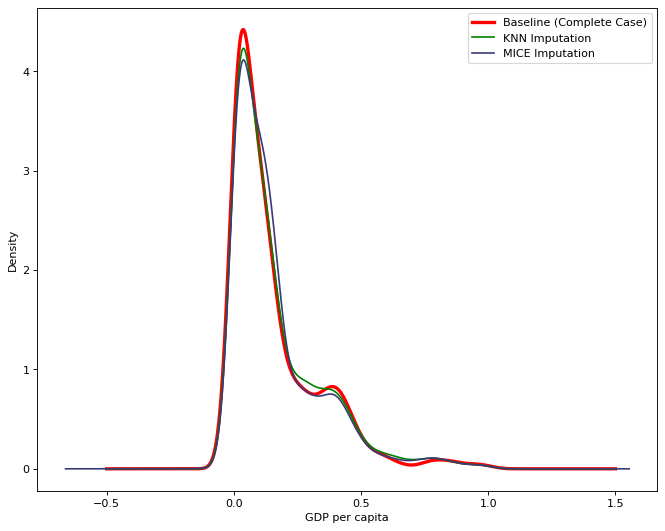

In [41]:
from matplotlib.pyplot import figure
# Changing size of the plot
figure(figsize=(10, 8), dpi=80)

# Adding density plots for different imputation to the plot for GDP per capita
alcohol_lm['GDP per capita'].plot(kind='kde', c='red', linewidth=3)
alcohol_knn['GDP per capita'].plot(kind='kde', c='green')
alcohol_mice['GDP per capita'].plot(kind='kde')
labels = ['Baseline (Complete Case)', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)
plt.xlabel('GDP per capita')

On the density plots we can see that values imputed by MICE are slightly closer to the baseline dataset. The model estimated for MICE dataset had also higher value of R squared, which suggests that it's the best method to impute the missing observations. We will continue with this dataset in the further analysis.

In [42]:
#Renaming the columns with the imputed data
alcohol_mice.rename({'GDP per capita':'GDP_per_capita_norm', 'Alcohol consumption':'Alcohol_consumption_norm',
                     'Alcohol disorders':'Alcohol_disorders_norm'},inplace=True,axis=1)
#concatenating the datasets
alcohol_final = pd.concat([alcohol, alcohol_mice], axis=1, ignore_index=False)

alcohol_final.tail(300)

,Country,ISO,Continent,Year,Sex,Alcohol disorders,Alcohol consumption,GDP per capita,Alcohol_disorders_norm,Alcohol_consumption_norm,GDP_per_capita_norm
2310,Iraq,IRQ,Asia,2018,Total,1.912586,0.39,10346.212958,0.014039,0.012203,0.086009
2311,Iraq,IRQ,Asia,2018,Female,0.200741,0.11,10346.212958,0.009270,0.003442,0.086009
2312,Iraq,IRQ,Asia,2018,Male,3.542651,0.67,10346.212958,0.018579,0.020964,0.086009
2313,Ireland,IRL,Europe,2018,Total,30.650402,12.88,84303.340892,0.094084,0.403004,0.740735
2314,Ireland,IRL,Europe,2018,Female,17.248742,6.38,84303.340892,0.056755,0.199625,0.740735
...,...,...,...,...,...,...,...,...,...,...,...
2605,Zambia,ZMB,Africa,2018,Female,14.014648,2.62,3521.542063,0.047747,0.081977,0.025592
2606,Zambia,ZMB,Africa,2018,Male,62.351931,10.62,3521.542063,0.182385,0.332290,0.025592
2607,Zimbabwe,ZWE,Africa,2018,Total,34.143938,4.67,3341.665418,0.103815,0.146120,0.024000
2608,Zimbabwe,ZWE,Africa,2018,Female,6.197438,1.63,3341.665418,0.025973,0.051001,0.024000


In [43]:
Analysis(alcohol_final)

Analysing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   2610 non-null   object 
 1   ISO                       2610 non-null   object 
 2   Continent                 2595 non-null   object 
 3   Year                      2610 non-null   int64  
 4   Sex                       2610 non-null   object 
 5   Alcohol disorders         2610 non-null   float64
 6   Alcohol consumption       2412 non-null   float64
 7   GDP per capita            2373 non-null   float64
 8   Alcohol_disorders_norm    2610 non-null   float64
 9   Alcohol_consumption_norm  2610 non-null   float64
 10  GDP_per_capita_norm       2610 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 309.2+ KB
None
                          Count         %
GDP per capita              237  9.080460
Alcohol consump

# Bayesian analysis

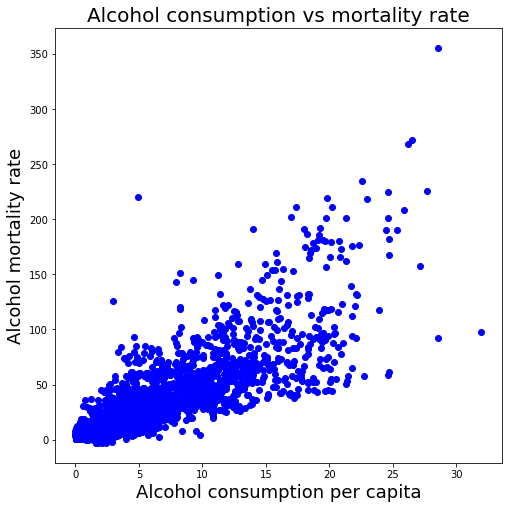

In [44]:
plt.figure(figsize=(8, 8))

plt.plot(alcohol_final['Alcohol consumption'], alcohol_final['Alcohol disorders'], 'bo');
plt.xlabel('Alcohol consumption per capita', size = 18); plt.ylabel('Alcohol mortality rate', size = 18); 
plt.title('Alcohol consumption vs mortality rate', size = 20);

The plot suggests that a relationship between alcohol consumption and  alcohol-related deaths can be linear. However, there are many outliers, especially as the alcohol consumption increases. This can suggest that there are other factors that affect the mortality. Now, we will estimate the OLS regression. 

In [45]:
# Estimating linear regression
X = sm.add_constant(alcohol_final[['Alcohol_consumption_norm','GDP_per_capita_norm']])
y = alcohol_final['Alcohol_disorders_norm']
lm = sm.OLS(y, X).fit()
print('\nAdjusted R-squared score: ', lm.rsquared_adj)
print('\nSummary: ', lm.summary())


Adjusted R-squared score:  0.7007396886520973

Summary:                                OLS Regression Results                              
Dep. Variable:     Alcohol_disorders_norm   R-squared:                       0.701
Model:                                OLS   Adj. R-squared:                  0.701
Method:                     Least Squares   F-statistic:                     3056.
Date:                    Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                            20:49:54   Log-Likelihood:                 3802.8
No. Observations:                    2610   AIC:                            -7600.
Df Residuals:                        2607   BIC:                            -7582.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



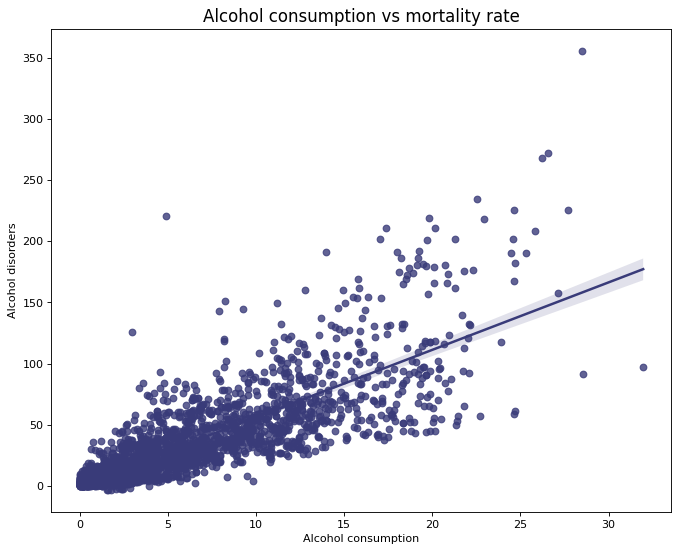

In [46]:
from matplotlib.pyplot import figure
#changing size of the plot
figure(figsize=(10, 8), dpi=80)

#plotting the regression
sns.regplot(x='Alcohol consumption', y='Alcohol disorders', data=alcohol_final)
plt.title('Alcohol consumption vs mortality rate', size = 15);


Bayesian model

In [47]:
# Defining formula of the model
formula = "Alcohol_disorders_norm ~ Alcohol_consumption_norm + GDP_per_capita_norm"
with pm.Model() as model:    
  pm.GLM.from_formula(formula, data=alcohol_final)
# Print model specification
  print(model)
# 1500 posterior draws are sampled, 750 burn-in draws are sampled and discarded and 4 chains are 
  trace = pm.sample(draws=1500, tune=750, chains=4)


The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


               Intercept ~ Flat
Alcohol_consumption_norm ~ Normal
     GDP_per_capita_norm ~ Normal
                sd_log__ ~ TransformedDistribution
                      sd ~ HalfCauchy
                       y ~ Normal


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, GDP_per_capita_norm, Alcohol_consumption_norm, Intercept]


Sampling 4 chains for 750 tune and 1_500 draw iterations (3_000 + 6_000 draws total) took 18 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7203814610>,
      dtype=object)

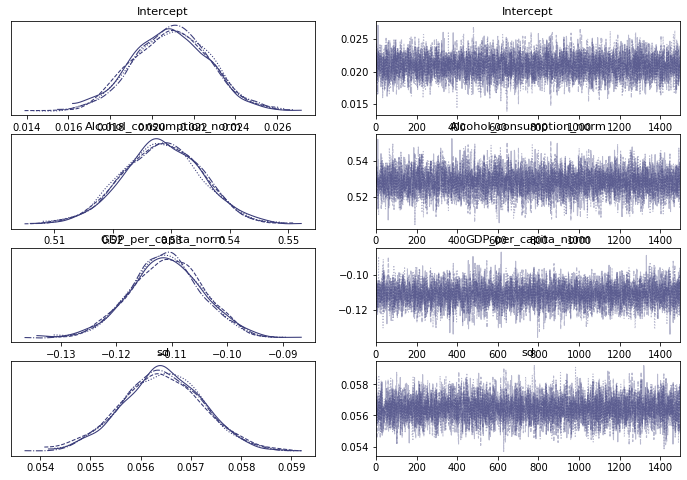

In [48]:
# Creating traceplot
pm.traceplot(trace)


Judging by the the density plots for different chains - they are very similar for each parameter. This indicates that they are sampled from the right posterior.  

All of the samples oscilate around a constant average, which suggests that the sampling has converged succesfully.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f72029c3410>],
      dtype=object)

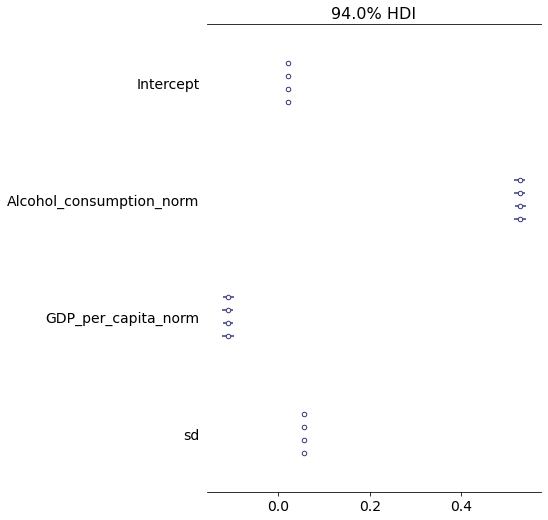

In [49]:
pm.forestplot(trace)


In [50]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.021,0.002,0.018,0.024,0.0,0.0,4559.0,3946.0,1.0
Alcohol_consumption_norm,0.528,0.007,0.515,0.540,0.0,0.0,4532.0,3889.0,1.0
GDP_per_capita_norm,-0.111,0.007,-0.122,-0.098,0.0,0.0,4962.0,3863.0,1.0
sd,0.056,0.001,0.055,0.058,0.0,0.0,5461.0,4242.0,1.0


The summary of the model gives us some indications about the determinants of alcohol related mortality. Firstly, the mean of alcohol consumption indicates a strong positive relationship with the alcohol related mortality. There is a negative association between GDP per capita and alcohol related mortality. We are pretty confident about the relationship direction for each of the estimate, as the 94% confident intervals don't show large discrepancies. R hat values have a value of 1, which confirms that all the chains converged succesfuly. Forestplot also suggests that the estimations are accurate.